In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from dataSet import SGNS_store_DataSet

from typing import Sequence, Optional, Callable, List, Dict

from copy import deepcopy

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

import seaborn as sns
import matplotlib.pyplot as plt

import unicodedata
import string

from visuEmbedding import components_to_fig_3D, components_to_fig_3D_animation
import tool

[nltk_data] Downloading package punkt_tab to /home/pe/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
class SkipGramModel(nn.Module):
    def __init__(self, emb_size:int, embedding_dimension:int=15, context_dimension:int|None=None, init_range:float|None=None, sparse:bool=True, device="cpu"):
        super().__init__()
        self.emb_size:int = emb_size
        self.emb_dim:int = embedding_dimension
        self.word_emb:nn.Embedding = nn.Embedding(num_embeddings=self.emb_size, embedding_dim=self.emb_dim, device=device, sparse=sparse)
        self.con_size = embedding_dimension if context_dimension is None else context_dimension
        self.con_emb:nn.Embedding = nn.Embedding(num_embeddings=self.emb_size, embedding_dim=self.con_size, device=device,sparse=sparse)

        if init_range is None:
            init_range = 0.5 / self.emb_dim
        self.word_emb.weight.data.uniform_(-init_range, init_range)
        self.con_emb.weight.data.uniform_(-init_range, init_range)

    def forward(self, centrals_words:list|torch.Tensor, pos_context:list|torch.Tensor, neg_context:list|torch.Tensor):
        words_emb:torch.Tensor = self.word_emb(centrals_words)
        context_emb:torch.Tensor = self.con_emb(pos_context) # [B, D]
        neg_emb:torch.Tensor = self.con_emb(neg_context) # [B, K, D]

        pos_score = torch.sum(words_emb * context_emb, dim=1)
        pos_loss = F.logsigmoid(pos_score)

        neg_score = torch.bmm(neg_emb, words_emb.unsqueeze(-1)).squeeze(2)
        neg_loss = F.logsigmoid(-neg_score).sum(1)

        loss = - (pos_loss + neg_loss).mean()
        return loss
    
    def save_weight(self, path:str="SGNS_weights/"):
        word_weights = self.word_emb.weight.detach().cpu()
        con_weight = self.con_emb.weight.detach().cpu()
        torch.save(word_weights, path+'word_embedding.pt')
        torch.save(con_weight, path+'con_embedding.pt')

    def load_weight(self, path:str="SGNS_weights/", name_word_weights:str="word_embedding.pt", name_con_weights:str="con_embedding.pt"):
        word_weights = torch.load(path + name_word_weights)
        con_weight = torch.load(path + name_con_weights)
        self.word_emb:nn.Embedding = nn.Embedding.from_pretrained(word_weights)
        self.con_emb:nn.Embedding = nn.Embedding.from_pretrained(con_weight)

In [ ]:
class OnlyOneEmb(nn.Module):
    def __init__(self, emb_size:int, embedding_dimension:int=15, init_range:float|None=None, sparse:bool=True, device="cpu"):
        super().__init__()
        self.emb_size:int = emb_size
        self.emb_dim:int = embedding_dimension
        self.word_emb:nn.Embedding = nn.Embedding(num_embeddings=self.emb_size, embedding_dim=self.emb_dim, device=device, sparse=sparse)

        if init_range is None:
            init_range = 0.5 / self.emb_dim
        self.word_emb.weight.data.uniform_(-init_range, init_range)

    def forward(self, centrals_words:list|torch.Tensor, pos_context:list|torch.Tensor, neg_context:list|torch.Tensor):
        words_emb:torch.Tensor = self.word_emb(centrals_words)
        context_emb:torch.Tensor = self.word_emb(pos_context) # [B, D]
        neg_emb:torch.Tensor = self.word_emb(neg_context) # [B, K, D]

        pos_score = torch.sum(words_emb * context_emb, dim=1)
        pos_loss = F.logsigmoid(pos_score)

        neg_score = torch.bmm(neg_emb, words_emb.unsqueeze(-1)).squeeze(2)
        neg_loss = F.logsigmoid(-neg_score).sum(1)

        loss = -(pos_loss + neg_loss).mean()
        return loss
    
    def save_weight(self, path:str="SGNS_weights/"):
        word_weights = self.word_emb.weight.detach().cpu()
        torch.save(word_weights, path+'word_embedding.pt')

    def load_weight(self, path:str="SGNS_weights/", name_word_weights:str="word_embedding.pt"):
        word_weights = torch.load(path + name_word_weights)
        self.word_emb:nn.Embedding = nn.Embedding.from_pretrained(word_weights)

In [4]:
def train_Word2Vec(modelW2V:nn.Module, dataLoader:Dataset, optimizer:optim.Optimizer, epochs:int, verbal:bool=True, log_interval=100, device="cpu"):
    """Fonction d’entraînement pour un modèle Word2Vec
    """
    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        batches = 0
        loss_history = []
        global_step = 0
        
        modelW2V.train()

        for batch in dataLoader:
            # centers: [B], pos: [B], negs: [B, K]
            centers, pos, negs = batch
            centers = centers.to(device)
            pos = pos.to(device)
            negs = negs.to(device)

            optimizer.zero_grad()
            loss = modelW2V(centers, pos, negs)
            loss.backward()

            optimizer.step()

            batch_loss = loss.item()
            epoch_loss += batch_loss
            loss_history.append(batch_loss)
            batches += 1
            global_step += 1

            if verbal and log_interval and (global_step % log_interval == 0):
                print(f"Epoch {epoch} Step {global_step} AvgLoss {epoch_loss / batches:.6f}")

        avg_epoch_loss = epoch_loss / max(1, batches)
        if verbal : print(f"Epoch {epoch} finished. Avg loss: {avg_epoch_loss:.6f}")

    return {"loss_history": loss_history, "final_epoch_loss": avg_epoch_loss}

In [5]:
class SGwithNorm(nn.Module):
    def __init__(self, emb_size:int, embedding_dimension:int=15, context_dimension:int|None=None, init_range:float|None=None, sparse:bool=True, device="cpu"):
        """Initialisation du modèle SkipGram
        Args:
            emb_size: La taille de l'embedding, ce nombre devrais être déterminé après le process sur les data, et dépend de la taille de la fenêtre glissante.
            embedding_dimension: La taille souhaité de l'embedding. Pour notre cas d'utilisation nous préférons une taille très petit
            context_dimension: Il n'est pas recommandé de mettre un entier mais de laisser a None.
        
        """
        super().__init__()
        self.emb_size:int = emb_size
        self.emb_dim:int = embedding_dimension
        self.word_emb:nn.Embedding = nn.Embedding(num_embeddings=self.emb_size, embedding_dim=self.emb_dim, device=device, sparse=sparse)

        self.con_size = embedding_dimension if context_dimension is None else context_dimension
        self.con_emb:nn.Embedding = nn.Embedding(num_embeddings=self.emb_size, embedding_dim=self.con_size, device=device,sparse=sparse)

        if init_range is None:
            init_range = 0.5 / self.emb_dim
        self.word_emb.weight.data.uniform_(-init_range, init_range)
        self.con_emb.weight.data.uniform_(-init_range, init_range)

        self.scale = nn.Parameter(torch.tensor(10.0, device=device))

    def forward(self, centrals_words:list|torch.Tensor, pos_context:list|torch.Tensor, neg_context:list|torch.Tensor):
        """Fonction du forward pour le modèle SkipGramModel
        Args:
            centrals_words: Liste des ids des tokens des mots centraux [B]
            pos_context: Liste des ids des tokens des mots dans le contexte [B]
            neg_context: Liste des ids des tokens des mots non présent dans le contexte [B, K]
        """
        words_emb:torch.Tensor = self.word_emb(centrals_words) # [B, D]
        context_emb:torch.Tensor = self.con_emb(pos_context)   # [B, D]
        neg_emb:torch.Tensor = self.con_emb(neg_context)       # [B, K, D]
        words_norm = F.normalize(words_emb, p=2, dim=1)
        context_norm = F.normalize(context_emb, p=2, dim=1)
        neg_norm = F.normalize(neg_emb, p=2, dim=2)


        pos_dot = torch.sum(words_norm * context_norm, dim=1)
        pos_score = pos_dot * self.scale # Scale up
        pos_loss = F.logsigmoid(pos_score)

        neg_dot = torch.bmm(neg_norm, words_norm.unsqueeze(-1)).squeeze(2)
        neg_score = neg_dot * self.scale # Scale up
        neg_loss = F.logsigmoid(-neg_score).sum(1)


        loss = - (pos_loss + neg_loss).mean()
        return loss

In [6]:
def pipe_data(
    language: str,
    dataseteur: Callable[..., object],
    window_size: int = 3,
    nb_neg: int = 3,
    subsample_thresh: float = 1.0,
    vocab_size_limit: Optional[int] = None,
    power:float =0.75,
    file: Optional[str] = None,
    files: Optional[list[str]] = None,
    sentences: Optional[List[List[str]]] = None,
    remove_accent: bool = True,
    remove_ponct: bool = True,
    keep_accent: bool = True,
    contraction_map: Optional[dict] = None,
    stop_words:List[str] = []
) -> object:
    """
    """
    if contraction_map is None:
        contraction_map = {
            "n't": " n't", "'re": " 're", "'ve": " 've", "'ll": " 'll",
            "'d": " 'd", "'s": " 's", "'m": " 'm"
        }

    if all([(files is None), (file is None), (sentences is None)],):
        raise AssertionError("One of files, file or sentence must not be None")

    if language not in {"english", "french", None}:
        raise ValueError("language must be 'english' or 'french' or None")

    def remove_accents(text: str) -> str:
        nk = unicodedata.normalize("NFKD", text)
        return "".join(ch for ch in nk if not unicodedata.combining(ch))

    keep = {"'", "’"} if keep_accent else set()
    base_punct = set(string.punctuation)
    extra_punct = set('“”‘’—–…«»')
    punct_to_remove = (base_punct | extra_punct) - keep
    TRANSL_TABLE = str.maketrans('', '', ''.join(sorted(punct_to_remove)))

    tokens_by_sentence: List[List[str]] = []

    if files is not None:
        for name_file in files:
            with open(name_file, encoding="utf-8") as f:
                for line in f:
                    s = line.strip().lower()
                    if not s:
                        continue
                    if remove_accent:
                        s = remove_accents(s)
                    for k, v in contraction_map.items():
                        s = s.replace(k, v)
                    if remove_ponct:
                        s = s.translate(TRANSL_TABLE)
                    s2 = [word for word in s.split() if word not in stop_words]
                    s = " ".join(s2)
                    toks = word_tokenize(s, language=language)
                    if toks:
                        tokens_by_sentence.append(toks)

    elif file is not None:
        with open(file, encoding="utf-8") as f:
            for line in f:
                s = line.strip().lower()
                if not s:
                    continue
                if remove_accent:
                    s = remove_accents(s)
                for k, v in contraction_map.items():
                    s = s.replace(k, v)
                if remove_ponct:
                    s = s.translate(TRANSL_TABLE)
                s2 = [word for word in s.split() if word not in stop_words]
                s = " ".join(s2)                
                if not s:
                    continue
                toks = word_tokenize(s, language=language)
                if toks:
                    tokens_by_sentence.append(toks)
    else:
        tokens_by_sentence = [list(s) for s in sentences if s]

    return dataseteur(
        sentences=tokens_by_sentence,
        window_size=window_size,
        nb_neg=nb_neg,
        subsample_thresh=subsample_thresh,
        power=power,
        vocab_size_limit=vocab_size_limit
    )

def cosine_similarity_matrix(embeddings:nn.Embedding) -> torch.Tensor:
    emb = embeddings.weight.detach()
    emb_norm = F.normalize(emb, p=2, dim=1)
    similarity_matrix = emb_norm @ emb_norm.t()
    return similarity_matrix

def update_sim_history(words: list[str], idx: List[int], cos_sim_history:Dict, similarity_matrix):
    num_words = len(words)

    for i in range(num_words):
        for j in range(num_words):
            similarity = ((similarity_matrix[idx[i], idx[j]] + 1) / 2) * 100
            cos_sim_history[words[i]][words[j]].append(round(float(similarity), 2))

def heat_map(words:List[str], similarity_matrix, figsize=(10, 8), save_file='tmp.png'):
    plt.close('all')
    plt.figure(figsize=figsize)
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=words, yticklabels=words, cbar=True, robust=False,
                vmin=0, vmax=100,
                square=False, linewidths=0.)

    plt.title("Matrix de Similarité Cosinus")
    plt.xlabel("Mots", fontstyle="italic")
    plt.ylabel("Mots", fontstyle="italic")
    plt.savefig(save_file)
    return plt

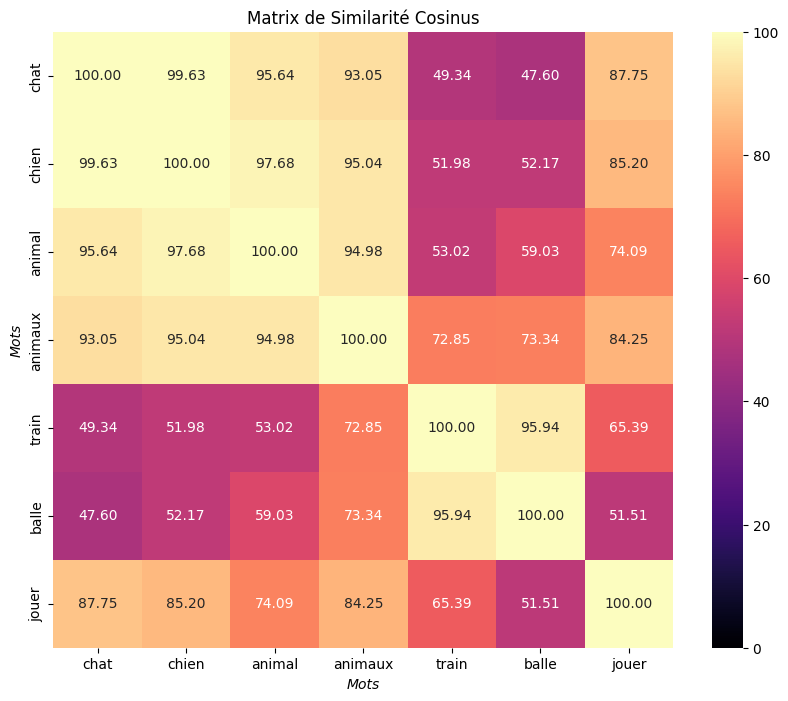

In [7]:
dataset:SGNS_store_DataSet = pipe_data(
    language="french",
    dataseteur=SGNS_store_DataSet,
    window_size = 3,
    nb_neg=5,
    subsample_thresh= 1,
    vocab_size_limit=None,
    file="data/GPT5v2.txt",
    remove_accent=True,
    remove_ponct=True,
    keep_accent= False,
    contraction_map=None,
    stop_words=["le", "les", "sur", "fait", "de", "et", "la", "des", "sont"] + \
    ["the", "your", "a", "rubber"]

)
data = DataLoader(dataset, batch_size=1, shuffle=True)

k = ["chat", "chien", "animal", "animaux","train", "balle", "jouer"]

modelW2V:SkipGramModel = SkipGramModel(dataset.vocab_size, embedding_dimension=3, init_range=None, sparse=False)
# optimizer = torch.optim.SparseAdam(modelW2V.parameters(), lr=0.01)
optimizer = torch.optim.Adam(modelW2V.parameters(), lr=0.01)

nb_epoch = 30
for _ in range(nb_epoch):
    for sentence_nb, (centers, pos, negs) in enumerate(data):
        optimizer.zero_grad()
        loss = modelW2V(centers, pos, negs)
        loss.backward()
        optimizer.step()

similarity = cosine_similarity_matrix(modelW2V.word_emb)
m_to_h = similarity
m_to_h = ((m_to_h + 1) / 2) * 100
m_to_h_2 = m_to_h[dataset.encode(k),:]
m_to_h_2 = m_to_h_2[:, dataset.encode(k)]
plt = heat_map(words=k, similarity_matrix=m_to_h_2)
plt.show()

components_to_fig_3D(components=modelW2V.word_emb.weight.detach().cpu().numpy(),
    encoder=dataset.encoder,
    words_display=list(dataset.encoder.keys()),
    highlight_words=k,
    nb_neighbors=2, _min=-5, _max=5, base_color={}
)

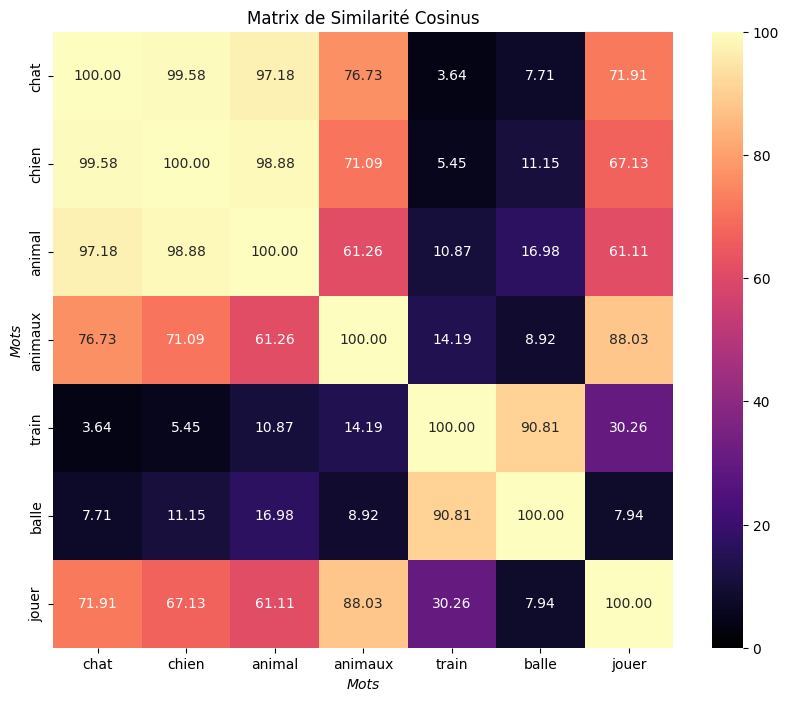

In [15]:
modelW2V:OnlyOneEmb = OnlyOneEmb(dataset.vocab_size, embedding_dimension=3, init_range=None, sparse=True)
# optimizer = torch.optim.Adam(modelW2V.parameters(), lr=0.01)
optimizer = torch.optim.SparseAdam(modelW2V.parameters(), lr=0.005)

emb_hist = []
nb_epoch = 30


for _ in range(nb_epoch):
    for sentence_nb, (centers, pos, negs) in enumerate(data):
        optimizer.zero_grad()
        loss = modelW2V(centers, pos, negs)
        loss.backward()
        optimizer.step()
        
    w = deepcopy(modelW2V.word_emb.weight.detach().cpu().numpy())
    emb_hist.append(w)

similarity = cosine_similarity_matrix(modelW2V.word_emb)
m_to_h = similarity
m_to_h = ((m_to_h + 1) / 2) * 100
m_to_h_2 = m_to_h[dataset.encode(k),:]
m_to_h_2 = m_to_h_2[:, dataset.encode(k)]
plt = heat_map(words=k, similarity_matrix=m_to_h_2)
plt.show()

In [11]:
base_colors = {
    'chat': ("blue",  "cyan"),
    'chien': ("goldenrod", "yellow"),
    'balle': ("green", "lightgreen"),
    "jouer": ("magenta", "pink")
}


fig = components_to_fig_3D_animation(
    history_components=emb_hist,
    encoder=dataset.encoder,
    highlight_words=["chat", "chien", "balle", "jouer", "animal", "animaux"],
    nb_neighbors=6, base_color=base_colors
)


modelW2V.save_weight()
tool.DicToJson(dataset.encoder, "data/encoder")
tool.DicToJson(dataset.decoder, "data/decoder")



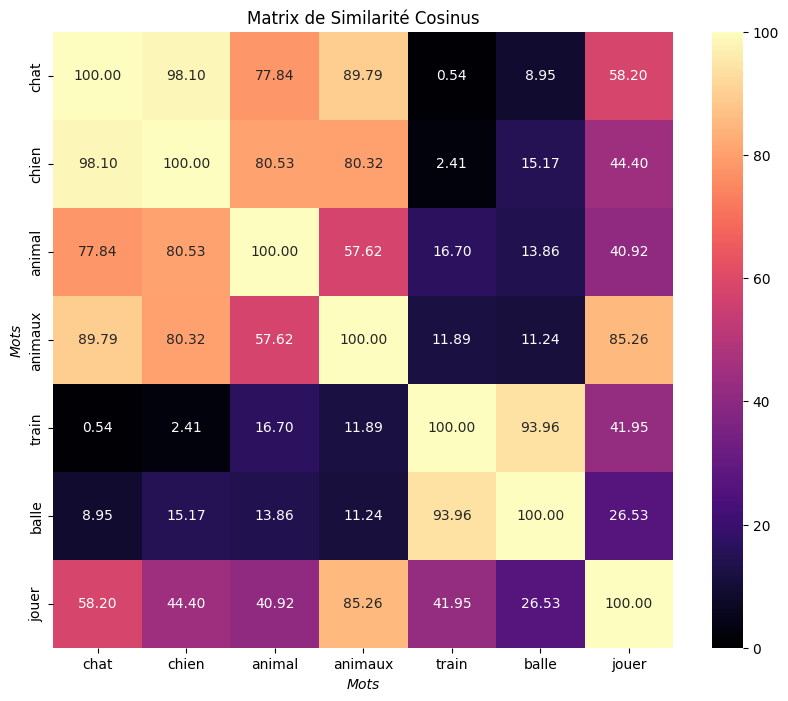

In [36]:
modelW2V:OnlyOneEmb = OnlyOneEmb(dataset.vocab_size, embedding_dimension=3, init_range=0.5, sparse=True)
# optimizer = torch.optim.Adam(modelW2V.parameters(), lr=0.01)
optimizer = torch.optim.SparseAdam(modelW2V.parameters(), lr=0.005)


with torch.no_grad():
    modelW2V.word_emb.weight[dataset.encoder['animal']] = torch.tensor([1, 0, 0.3])
    modelW2V.word_emb.weight[dataset.encoder['train']] = torch.tensor([-1, 0, 0])

emb_hist = []
nb_epoch = 10

w = deepcopy(modelW2V.word_emb.weight.detach().cpu().numpy())
emb_hist.append(w)
for _ in range(nb_epoch):
    for sentence_nb, (centers, pos, negs) in enumerate(data):
        optimizer.zero_grad()
        loss = modelW2V(centers, pos, negs)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        modelW2V.word_emb.weight[dataset.encoder['animal']] = torch.tensor([1, 0, 0.3])
        
    w = deepcopy(modelW2V.word_emb.weight.detach().cpu().numpy())
    emb_hist.append(w)

similarity = cosine_similarity_matrix(modelW2V.word_emb)
m_to_h = similarity
m_to_h = ((m_to_h + 1) / 2) * 100
m_to_h_2 = m_to_h[dataset.encode(k),:]
m_to_h_2 = m_to_h_2[:, dataset.encode(k)]
plt = heat_map(words=k, similarity_matrix=m_to_h_2)
plt.show()

In [37]:
fig = components_to_fig_3D_animation(
    history_components=emb_hist,
    encoder=dataset.encoder,
    highlight_words=["chat", "chien", "train", "jouer", "animal", "animaux"],
    nb_neighbors=6, base_color=base_colors
)